In [6]:
import pandas as pd
import numpy as np
import os
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [7]:
os.getcwd()

'/workspaces/Problem_set2_BDML'

In [8]:
casas = pd.read_csv('/workspaces/Problem_set2_BDML/stores/base_datos_tratada.csv')

Intentaremos hacer un modelo de k-vecinos para solucionar el problema de missing values en variables importantes para nuestro estudio

<Axes: >

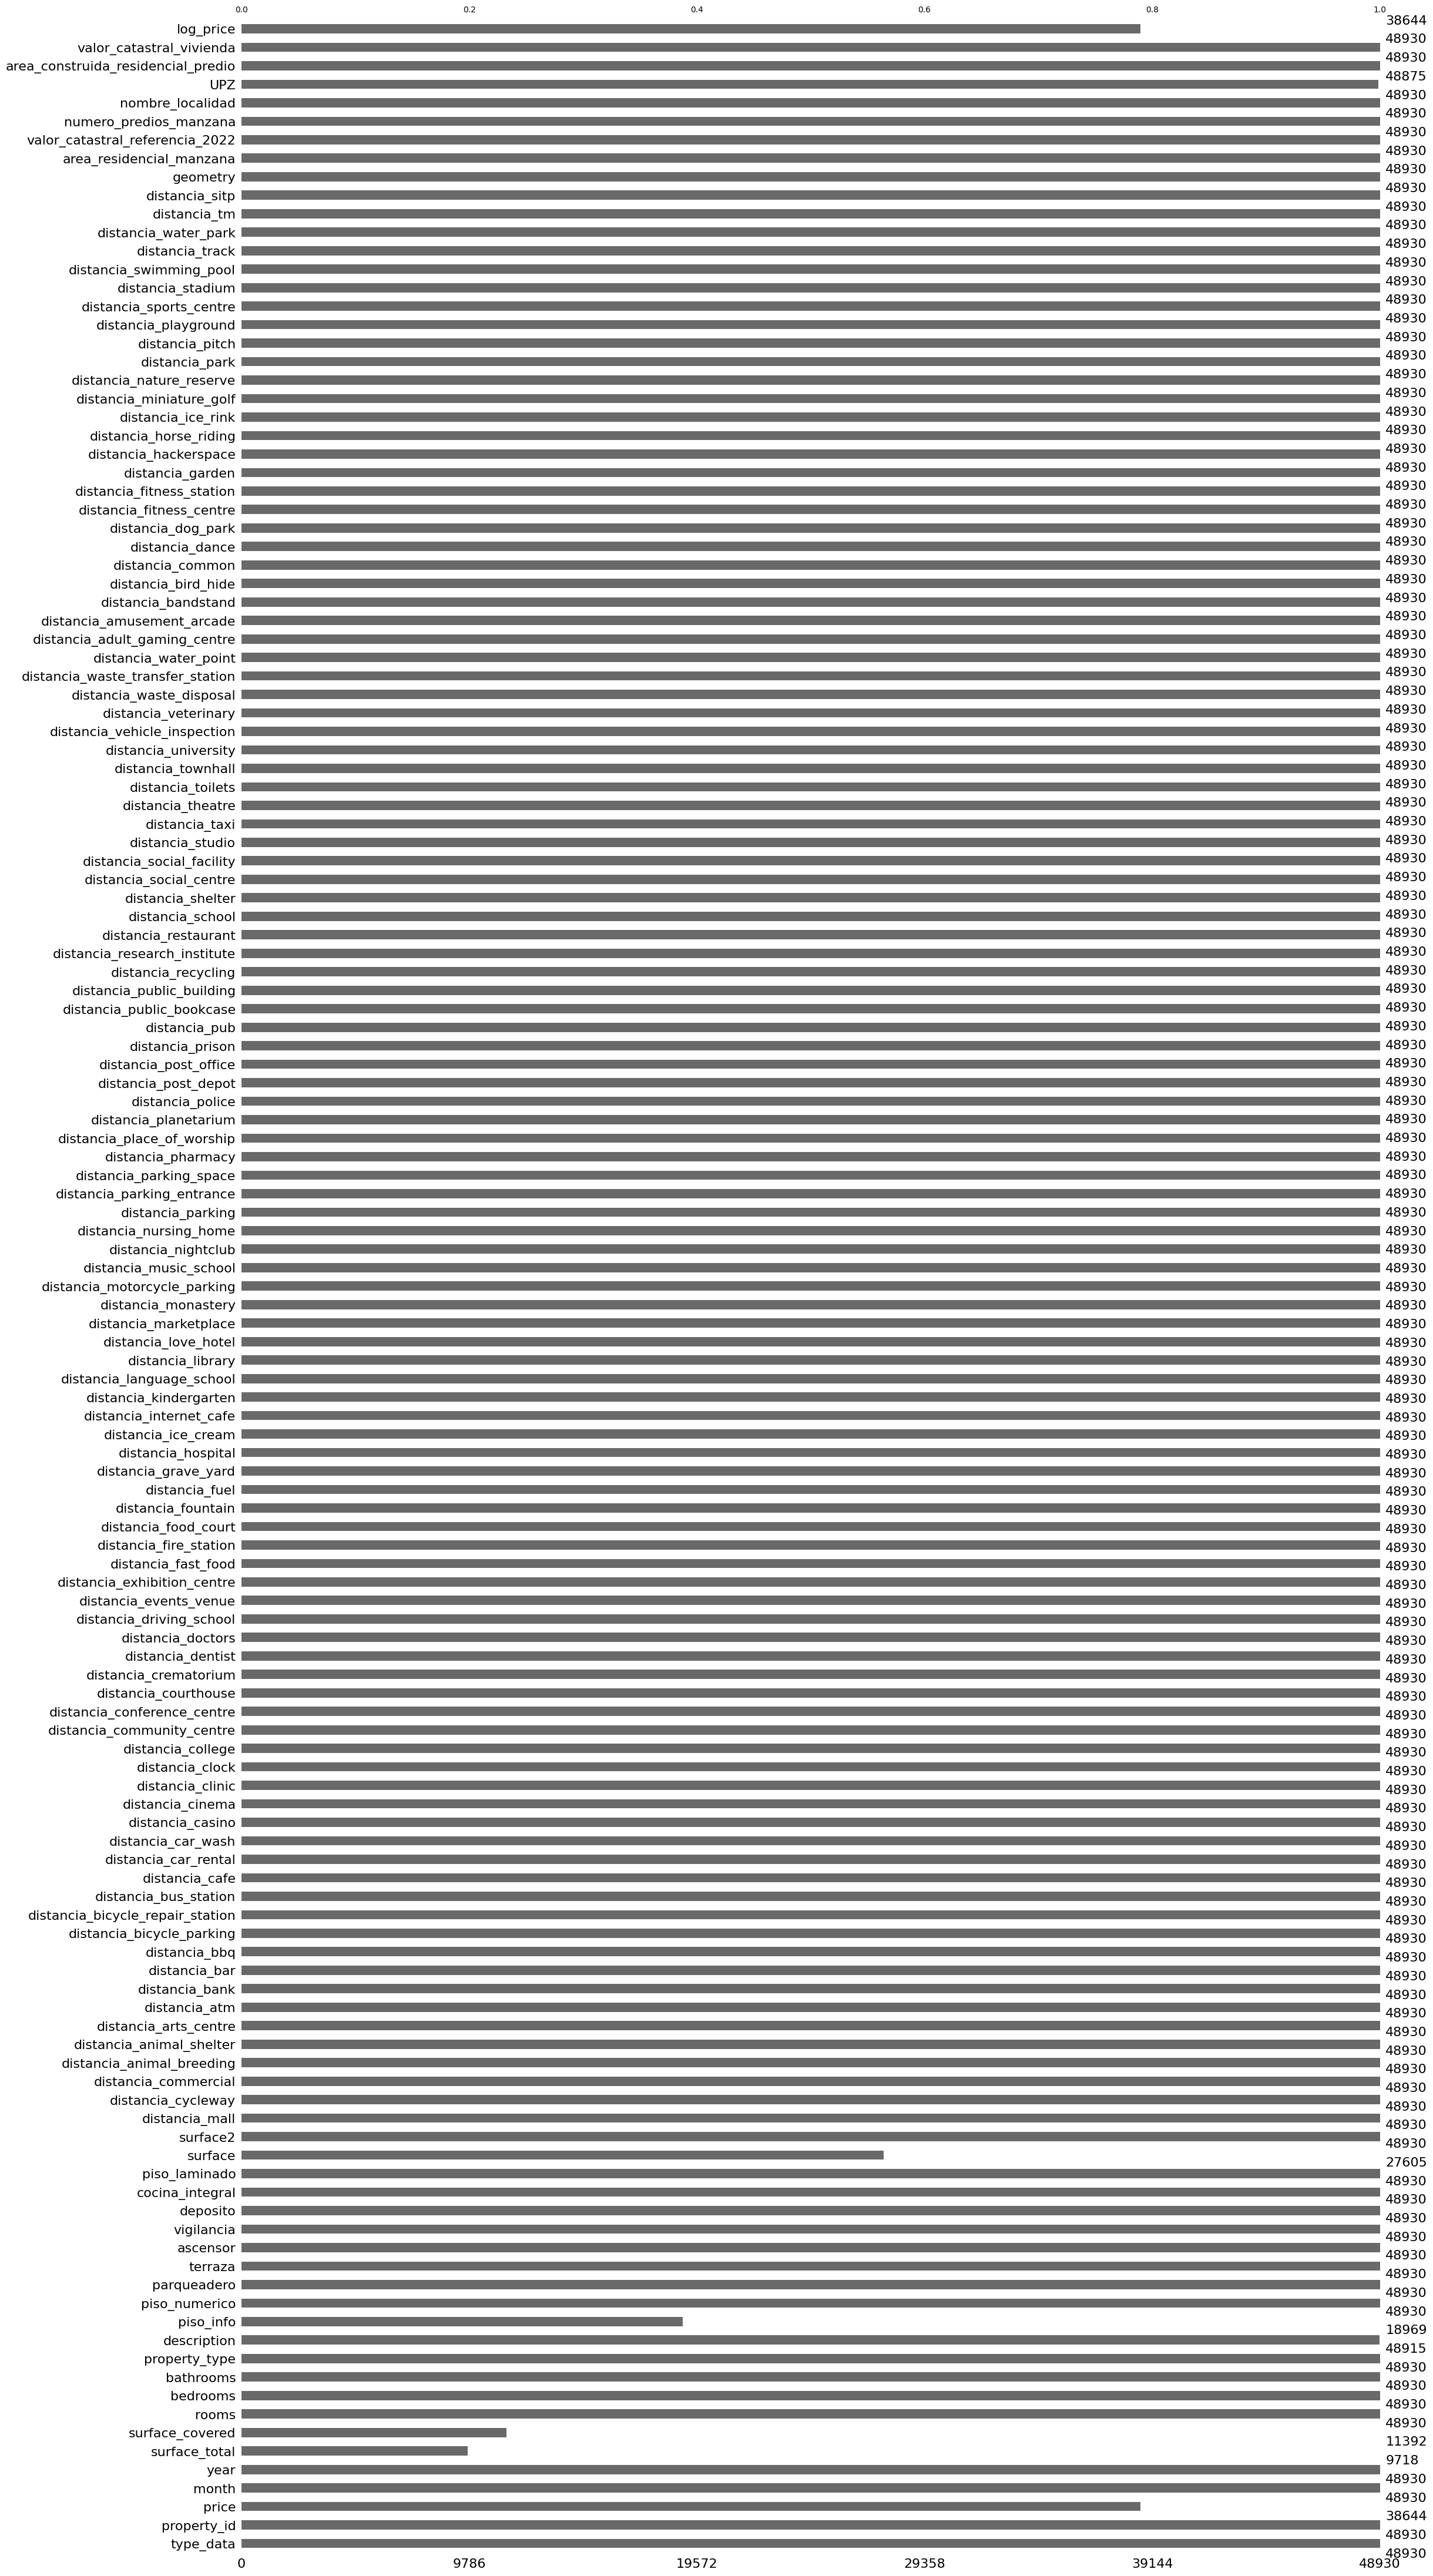

In [9]:
msno.bar(casas)

In [10]:
casas_knn = casas

In [11]:
#Quitamos las variables no numericas
casas_knn = casas_knn.select_dtypes(exclude = ['object'])
casas_knn = casas_knn.reset_index(drop = True)

El modelo de imputación por k-vecinos imputará todos los valores faltantes de la base que usemos. Para no afectar la variable objetivo del taller (price) se eliminará temporalmente. La variable objetivo de este modelo será rooms

In [12]:
#Comenzamos con un modelo sencillo
imputacion = KNNImputer(n_neighbors = 1, weights = 'distance')

In [13]:
casas_knn = casas_knn.drop(['price'], axis=1)
casas_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48930 entries, 0 to 48929
Columns: 121 entries, month to log_price
dtypes: float64(115), int64(6)
memory usage: 45.2 MB


In [14]:
x = casas_knn.drop(columns = ['rooms'])
y = casas_knn['rooms']
# Dividimos la muestra
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)

# Normalizamos los datos
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [15]:
#Comenzamos con un modelo sencillo
imputacion = KNNImputer(n_neighbors = 1, weights = 'distance')

In [17]:
#Lo implementamos
x_train_imputed = imputacion.fit_transform(x_train)
x_test_imputed = imputacion.transform(x_test)

Vamos a calibrar el hiper parametro usando cross-validation

In [18]:
# Creamos un nuevo modelo
knn2 = KNeighborsRegressor()

# Creamos un rango de valores para probar
param_grid = {'n_neighbors': np.arange(1, 30)}

# Implementamos y luego hacemos fit
# Estamos haciendo un cross-validation de 200 grupos
knn_casas_grid = GridSearchCV(knn2, param_grid, cv = 200)
knn_casas_grid.fit(x_train_imputed, y_train)

#Hiperparametro
n_vecinos = knn_casas_grid.best_params_['n_neighbors']
#Acuracy
accuracy = knn_casas_grid.best_score_ * 100

#Interpretamos
print(f"El mejor número de vecinos es: {n_vecinos}")
print(f"Estamos prediciendo un {accuracy:.2f}% del número de cuartos.")

El mejor número de vecinos es: 3
Estamos prediciendo un 80.76% del número de cuartos.


In [19]:
imputacion = KNNImputer(n_neighbors = n_vecinos, weights = 'distance')

x_train_imputed = imputacion.fit_transform(x_train)
x_test_imputed = imputacion.transform(x_test)

Procedemos a consolidar la nueva base de datos

In [20]:
# Escalar los datos de vuelta a su forma original
x_train_original = scaler.inverse_transform(x_train_imputed)
x_test_original = scaler.inverse_transform(x_test_imputed)

In [22]:
#Convertimos los arrays predichos en dataframes
x_train_original_df = pd.DataFrame(x_train_original)

#Nombramos columnas
column_names = list(casas_knn.columns)
# Eliminamos rooms porque lo habiamos eliminado
column_names.pop(5)
x_train_original_df.columns = column_names

x_train_original_df.head()

,month,year,surface_total,surface_covered,rooms,bathrooms,piso_numerico,surface,surface2,distancia_mall,...,distancia_track,distancia_water_park,distancia_tm,distancia_sitp,area_residencial_manzana,valor_catastral_referencia_2022,numero_predios_manzana,area_construida_residencial_predio,valor_catastral_vivienda,log_price
0,8.0,2019.0,77.000000,189.452024,3.0,2.0,2.0,14.141372,827.74929,494.223473,...,206.143008,5678.672850,448.529794,71.888621,1624.760000,2.850000e+06,12.000000,135.396667,3.858805e+08,19.831668
1,4.0,2020.0,107.219313,89.582658,2.0,2.0,2.0,40.000000,40.00000,1192.570494,...,2538.410175,4833.643768,879.115247,194.760928,19298.224728,4.812655e+06,329.811626,58.512870,2.816023e+08,20.069339
2,5.0,2021.0,101.620843,85.773239,3.0,2.0,11.0,82.000000,82.00000,1966.320072,...,828.860778,1037.887050,356.118598,237.820770,59013.650000,2.700000e+06,1724.000000,34.230655,9.242277e+07,19.902285
3,8.0,2020.0,289.000000,410.000000,10.0,5.0,1.0,410.000000,410.00000,902.192656,...,698.772066,3084.975443,196.939371,120.328966,3967.330000,3.900000e+06,52.000000,76.294808,2.975498e+08,21.224041
4,11.0,2019.0,152.228883,97.218343,2.0,2.0,2.0,115.000000,115.00000,552.462143,...,2708.860778,2135.338618,782.969385,96.519630,30007.371315,6.264217e+06,351.869417,85.279851,5.342115e+08,20.585641


In [23]:
#Convertimos los arrays predichos en dataframes
x_test_original_df = pd.DataFrame(x_test_original)

#Nombramos columnas
column_names = list(casas_knn.columns)
# Eliminamos rooms porque lo habiamos eliminado
column_names.pop(5)
x_test_original_df.columns = column_names

x_test_original_df.head()


,month,year,surface_total,surface_covered,rooms,bathrooms,piso_numerico,surface,surface2,distancia_mall,...,distancia_track,distancia_water_park,distancia_tm,distancia_sitp,area_residencial_manzana,valor_catastral_referencia_2022,numero_predios_manzana,area_construida_residencial_predio,valor_catastral_vivienda,log_price
0,5.0,2019.0,81.193653,81.000000,2.0,2.0,2.0,81.000000,81.00000,303.500537,...,3848.765849,6168.326745,1697.049281,339.690072,23425.20000,4.700000e+06,359.000000,65.251253,3.066809e+08,19.755682
1,11.0,2020.0,83.899041,103.448358,3.0,3.0,2.0,359.603222,827.74929,494.118224,...,1343.743407,2946.034626,906.859074,419.231357,120463.59000,6.770480e+06,3363.000000,35.820277,2.425205e+08,20.069339
2,10.0,2019.0,138.000000,138.000000,3.0,2.0,1.0,138.000000,138.00000,532.157214,...,3076.822450,2195.684129,1005.397394,125.125636,34330.33000,6.000000e+06,376.000000,91.304069,5.478244e+08,20.595072
3,2.0,2021.0,69.678968,163.716660,3.0,3.0,2.0,117.371027,827.74929,865.331640,...,1141.720683,9861.345731,2429.334091,8.551647,26508.24037,2.402507e+06,391.032258,67.790418,1.628669e+08,20.512545
4,9.0,2020.0,167.664358,188.000000,3.0,4.0,2.0,188.000000,188.00000,986.467180,...,4432.379485,7110.795132,2825.074884,26.862079,23393.00000,5.300000e+06,445.000000,52.568539,2.786133e+08,21.059738


In [24]:
#Unimos las bases de train y test
data = pd.concat([x_train_original_df, x_test_original_df])

Solo vamos a dejar las variables imputadas que tenian missing values para unirlas a la base original

In [25]:
columnas_para_unir = ['surface_total', 'surface_covered']

data = data[columnas_para_unir]
renombrar_columnas = {
    'surface_total': 'surface_total_kv',
    'surface_covered': 'surface_covered_kv',
}
data = data.rename(columns = renombrar_columnas)
data.head()

,surface_total_kv,surface_covered_kv
0,77.000000,189.452024
1,107.219313,89.582658
2,101.620843,85.773239
3,289.000000,410.000000
4,152.228883,97.218343


In [26]:
#Unimos las variables imputadas a la base original
casas_con_data = casas.merge(data, left_index = True, right_index = True, how = 'left')

In [27]:
#Revisamos missing values en la nueva base
casas_con_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58716 entries, 0 to 48929
Columns: 139 entries, type_data to surface_covered_kv
dtypes: float64(118), int64(6), object(15)
memory usage: 62.7+ MB


In [32]:
ruta_archivo = '/workspaces/Problem_set2_BDML/stores/base_datos_kvecinos.csv'
if os.path.exists(ruta_archivo):
    print("El archivo se ha guardado correctamente.")
else:
    print("No se ha podido guardar el archivo.")

El archivo se ha guardado correctamente.


In [30]:
#Guardamos la base
casas_con_data.to_csv('/workspaces/Problem_set2_BDML/stores/base_datos_kvecinos.csv', index = False)